Alexandros Milonakis AM:3045

In [2]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats


In [3]:
census_data_path = 'C:/Users/Alekos/Desktop/Εξορυξη Δεδομενων/1B/Census_Data.csv'
attribute_values_path = 'C:/Users/Alekos/Desktop/Εξορυξη Δεδομενων/1B/Attribute_Values.csv'


census_data = pd.read_csv(census_data_path)
attribute_values = pd.read_csv(attribute_values_path)




In [4]:
#Βημα 0
#φτιαχνω ενα αντιγραφο του attribute values για διευκολυνση και να κρατησω τα αρχικα values σε περιπτωση που τα χρειαστω
attribute_values_renewed = attribute_values.copy()

#Αλλαζω τα values του Place of Birth(<99 εκτος του 66)  σε Us
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='PoB')
    &((attribute_values_renewed['NumValue']<60) 
    |(attribute_values_renewed['NumValue']>60) &  (attribute_values_renewed['NumValue']<100))
    ,'Value'] = 'US'

#Αλλαζω τα values του Place of Birth (66 και >99) σε Not Us
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='PoB')
    &((attribute_values_renewed['NumValue']==60) 
    |(attribute_values_renewed['NumValue']>99) )
    ,'Value'] = 'Not US'  

#Αλλαζω τα values για το Category of Work
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='CoW')
    &(attribute_values_renewed['NumValue']<3) 
    ,'Value'] = 'Private Employee'     

attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='CoW')
    &((attribute_values_renewed['NumValue']>=3) 
    &(attribute_values_renewed['NumValue']<6) )
    ,'Value'] = 'Government Employee'         

attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='CoW')
    &((attribute_values_renewed['NumValue']>=6) 
    &(attribute_values_renewed['NumValue']<8) )
    ,'Value'] = 'Self-Employed'

attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='CoW')
    &(attribute_values_renewed['NumValue']==8) 
    ,'Value'] = 'No Pay' 

attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='CoW')
    &(attribute_values_renewed['NumValue']==9) 
    ,'Value'] = 'Unemployed' 

#κραταω το occupation και το education με τα numerical values τους
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='occupation') 
    ,'Value'] = attribute_values_renewed['NumValue']
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute']=='education') 
    ,'Value'] = attribute_values_renewed['NumValue']

#αλλαγες για το state. Απαλοιφη του abbreviation
attribute_values_renewed.loc[
    (attribute_values_renewed['Attribute'] == 'state'), 
    'Value'
] = attribute_values_renewed['Value'].str.split('/').str[0]

In [5]:
unique_attributes = attribute_values_renewed['Attribute'].unique()
for attribute in unique_attributes:
    to_change_subset = attribute_values_renewed[attribute_values_renewed['Attribute'] == attribute]
    census_data = census_data.merge(
        to_change_subset[['NumValue', 'Value']],
        left_on=attribute,  # Column in main dataset
        right_on='NumValue',  # Column in mapping
        how='left'
    )
    
    #Αντικαθιστώ την αρχική αριθμητική στήλη με την αντιστοιχισμένη τιμή.
    census_data[attribute] = census_data['Value']
    
    #Αφαιρώ τις επιπλέον στήλες από τη συγχώνευση
    census_data.drop(columns=['NumValue', 'Value'], inplace=True)
    


In [6]:
#Βήμα 1
#Συνάρτηση για να φτιάξω τους κάδους
def create_bins(data, thresholds):
    bins = []
    current_bin = []
    threshold_index = 0

    for value in data:
        if threshold_index < len(thresholds) and value > thresholds[threshold_index]:
            bins.append(current_bin) 
            current_bin = []  
            threshold_index += 1
        current_bin.append(value)
    
    bins.append(current_bin) 
    return bins

#Συνάρτηση για να βρώ τα κατώφλια για τους κάδους 
def find_bins(max_value,data,first_threshold):
    threshold_list = [first_threshold]
    to_next_threshold=first_threshold
    data = np.sort(data)
    while threshold_list[-1] < max_value:
        new_threshold = threshold_list[-1]+2 * to_next_threshold
        threshold_list.append(new_threshold)
        to_next_threshold = 2*to_next_threshold
    
    bins = create_bins(data,threshold_list)
    return bins,threshold_list

In [7]:

def find_cumulative_frequency_vector(data):
    cumulative_frequency_vectors =[]
    for i in range(len(data)):
        cumulative_frequency_vector = len(data)-i  
        cumulative_frequency_vectors.append(cumulative_frequency_vector)
    return cumulative_frequency_vectors

In [8]:
def find_zipf_ranking(data):
    ranking =[]
    for i in range(len(data)):
        ranking.append(i+1)
    return ranking

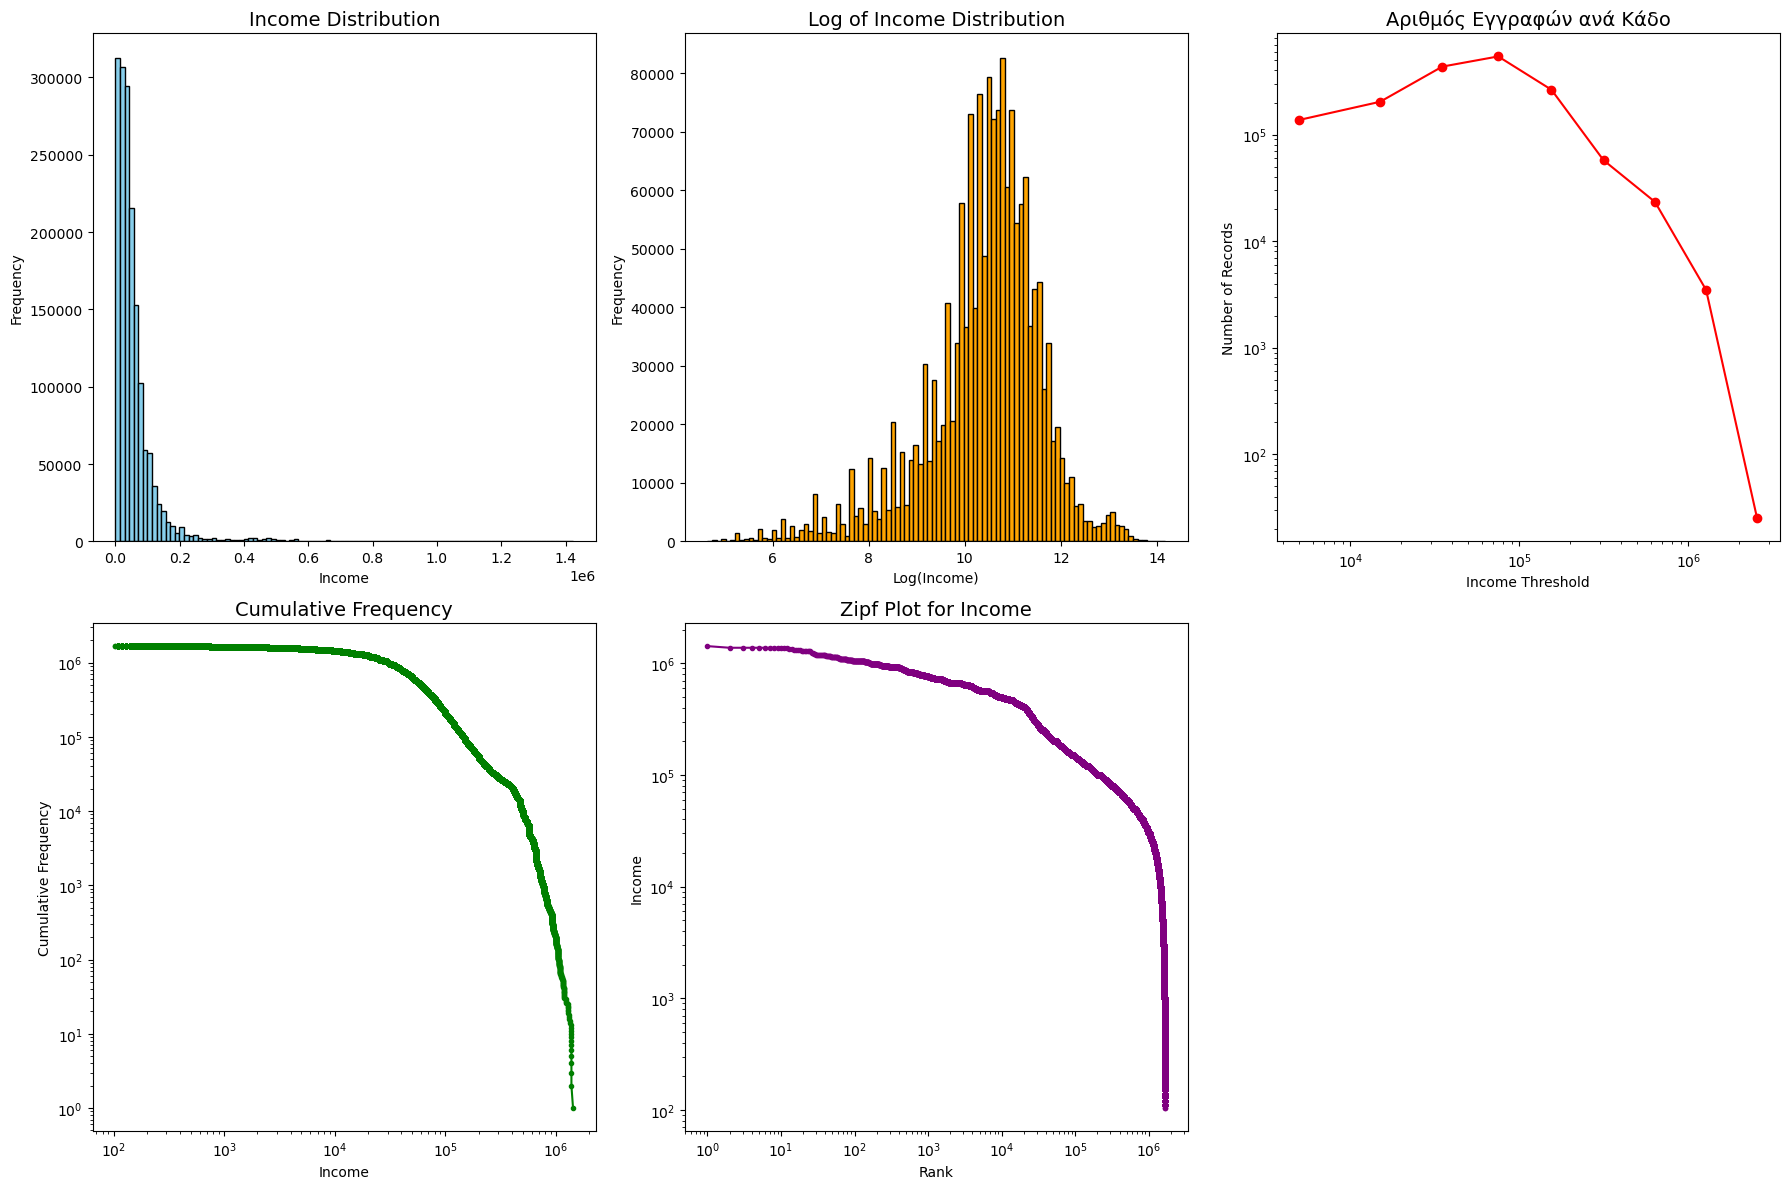

In [9]:
income = census_data['income']
census_data['log_income']  = np.log(income)
log_income = census_data['log_income']
# Δημιουργία υποδιαγραμμάτων σε grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Κατανομή Εισοδήματος
axes[0, 0].hist(income, bins=100, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Income Distribution', fontsize=14)
axes[0, 0].set_xlabel('Income')
axes[0, 0].set_ylabel('Frequency')

# 2. Κατανομή Λογαριθμικού Εισοδήματος
axes[0, 1].hist(log_income, bins=100, color='orange', edgecolor='black')
axes[0, 1].set_title('Log of Income Distribution', fontsize=14)
axes[0, 1].set_xlabel('Log(Income)')
axes[0, 1].set_ylabel('Frequency')

# 3. Αριθμός Εγγραφών ανά Κάδο
max_income = census_data['income'].max()
bins,threshold_list = find_bins(max_income,income,5000)
bin_counts = [len(bin) for bin in bins]
axes[0, 2].loglog(threshold_list,bin_counts, marker='o', color='red')
axes[0, 2].set_title("Αριθμός Εγγραφών ανά Κάδο", fontsize=14)
axes[0, 2].set_xlabel("Income Threshold")
axes[0, 2].set_ylabel("Number of Records")

# 3. Cumulative Frequency σε Λογαριθμική Κλίμακα
sorted_income = np.sort(income)[::]
cumulative_frequency = find_cumulative_frequency_vector(sorted_income)
axes[1, 0].loglog(sorted_income, cumulative_frequency, color='green', marker='.')
axes[1, 0].set_title('Cumulative Frequency', fontsize=14)
axes[1, 0].set_xlabel('Income')
axes[1, 0].set_ylabel('Cumulative Frequency')

# 4. Zipf Plot
reverse_sorted_income = sorted_income[::-1]
rank = find_zipf_ranking(reverse_sorted_income)
axes[1, 1].loglog(rank, reverse_sorted_income, color='purple', marker='.')
axes[1, 1].set_title('Zipf Plot for Income', fontsize=14)
axes[1, 1].set_xlabel('Rank')
axes[1, 1].set_ylabel('Income')



# Αφαίρεση κενών υποδιαγραμμάτων
axes[1, 2].axis('off')

# Ρύθμιση διαστάσεων και εμφάνιση
plt.tight_layout()
plt.show()

Income Distribution:
Το ιστόγραμμα δείχνει ότι τα περισσότερα εισοδήματα συγκεντρώνονται κοντά σε χαμηλές τιμές, με μια πολύ μικρή μειοψηφία να έχει υψηλά εισοδήματα. 
Log of Income Distribution:
Ο λογάριθμος του εισοδήματος δημιουργεί μια κατανομή πιο συμμετρική, με σχήμα που πλησιάζει την κανονική κατανομή. Αυτή η προσέγγιση δείχνει ότι η λογαριθμική κλίμακα είναι κατάλληλη για την καλύτερη ανάλυση της εισοδηματικής κατανομής.
Ιστόγραμμα με Εκθετικά Αυξανόμενους Κάδους:
Το γράφημα δείχνει πόσες καταγραφές περιλαμβάνονται σε κάθε κάδο(bin). Η λογαριθμική κλίμακα και στους δύο άξονες υπογραμμίζει ότι οι χαμηλότεροι κάδοι περιέχουν τη συντριπτική πλειοψηφία των παρατηρήσεων, ενώ οι υψηλότεροι έχουν λίγες.
Cumulative Frequency:
Αυτό το γράφημα δείχνει το πλήθος των ατόμων με εισοδήματα τουλάχιστον ίσα με κάθε συγκεκριμένη τιμή. Η λογαριθμική κλίμακα υποδεικνύει ότι η πτώση είναι απότομη, κάτι που επιβεβαιώνει τη συγκέντρωση του εισοδήματος σε χαμηλές τιμές.
Zipf Plot για το Εισόδημα:
Το Zipf plot δείχνει ότι τα μεγαλύτερα εισοδήματα είναι σπάνια, αλλά εξαιρετικά υψηλά σε σχέση με τα μικρότερα.


Υπάρχει στατιστική συσχέτιση μεταξύ του φύλου και της κατηγορίας εργασίας.
Lift: 
[[1.13288305 1.00533455 1.00299166 0.79012867]
 [0.87769105 0.99508995 0.9972464  1.19317093]]


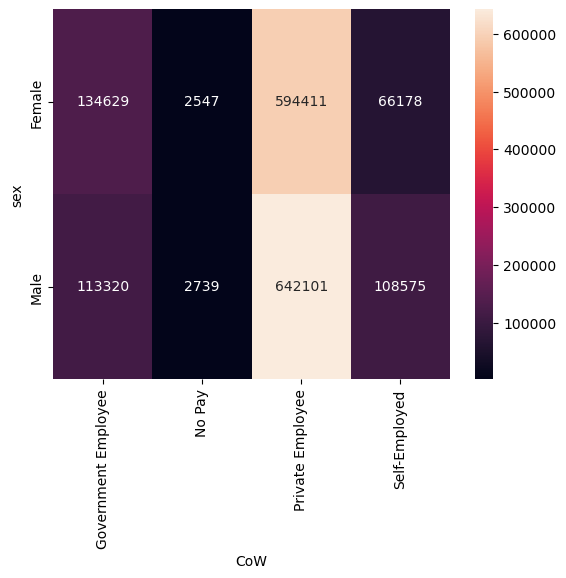

In [10]:
#Βήμα 2

correlation_sex_cow = pd.crosstab(census_data['sex'], census_data['CoW'])
sns.heatmap(correlation_sex_cow, annot=True, fmt='d')
chi2, p, dof, expected = stats.chi2_contingency(correlation_sex_cow)
if p < 0.05:
    print("Υπάρχει στατιστική συσχέτιση μεταξύ του φύλου και της κατηγορίας εργασίας.")
else:
    print("Δεν υπάρχει στατιστική συσχέτιση μεταξύ του φύλου και της κατηγορίας εργασίας.")

real_price = correlation_sex_cow.values
lift = real_price/expected
print(f"Lift: \n{lift}")

Υπάρχει στατιστική συσχέτιση μεταξύ του φυλης και της κατηγορίας εργασίας.
Lift: 
[[2.96382961 1.04267677 0.63888946 0.76745659]
 [1.95287374 1.1125862  0.84694798 0.72756659]
 [1.15819671 1.04763246 1.00447558 0.74243301]
 [0.80320954 1.26740623 1.04835477 0.9289811 ]
 [1.30292037 0.49503707 1.00900329 0.52176934]
 [1.2003826  0.44776166 1.02215552 0.57562328]
 [0.64891875 0.82131296 1.08917603 0.87254901]
 [1.06278968 1.0166192  1.01808467 0.78244496]
 [0.98437314 1.04572578 0.99208199 1.0768151 ]]


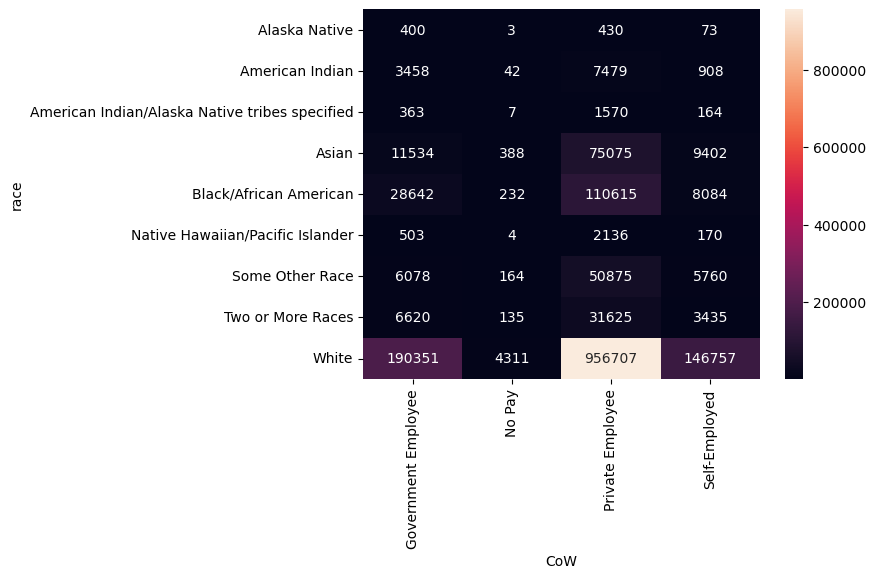

In [11]:
correlation_race_cow = pd.crosstab(census_data['race'], census_data['CoW'])
sns.heatmap(correlation_race_cow, annot=True, fmt='d')
chi2, p, dof, expected = stats.chi2_contingency(correlation_race_cow)
if p < 0.05:
    print("Υπάρχει στατιστική συσχέτιση μεταξύ του φυλης και της κατηγορίας εργασίας.")
else:
    print("Δεν υπάρχει στατιστική συσχέτιση μεταξύ του φύλου και της κατηγορίας εργασίας.")

real_price = correlation_race_cow.values
lift = real_price/expected
print(f"Lift: \n{lift}")

Υπάρχει στατιστική συσχέτιση μεταξύ του μέρους οπου γενήθηκε ένας άνθρωπος και της κατηγορίας εργασίας.
Lift: 
[[0.69327507 1.05288806 1.03571217 1.18090703]
 [1.05590362 0.99036063 0.99349111 0.96702792]]


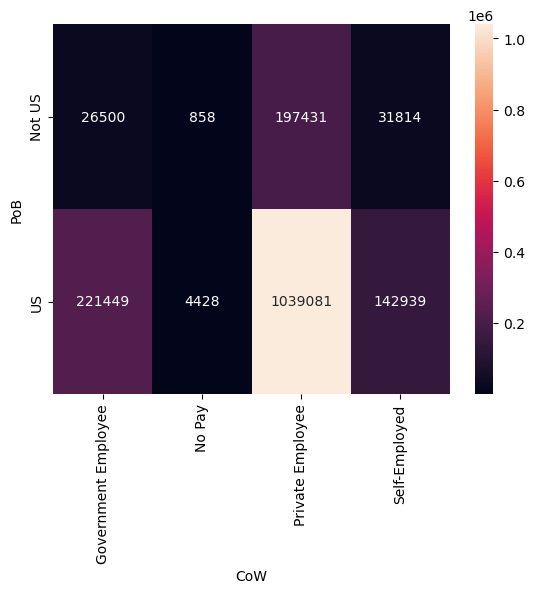

In [12]:
correlation_pob_cow = pd.crosstab(census_data['PoB'], census_data['CoW'])
sns.heatmap(correlation_pob_cow, annot=True, fmt='d')
chi2, p, dof, expected = stats.chi2_contingency(correlation_pob_cow)
if p < 0.05:
    print("Υπάρχει στατιστική συσχέτιση μεταξύ του μέρους οπου γενήθηκε ένας άνθρωπος και της κατηγορίας εργασίας.")
else:
    print("Δεν υπάρχει στατιστική συσχέτιση μεταξύ του φύλου και της κατηγορίας εργασίας.")

real_price = correlation_pob_cow.values
lift = real_price/expected
print(f"Lift: \n{lift}")

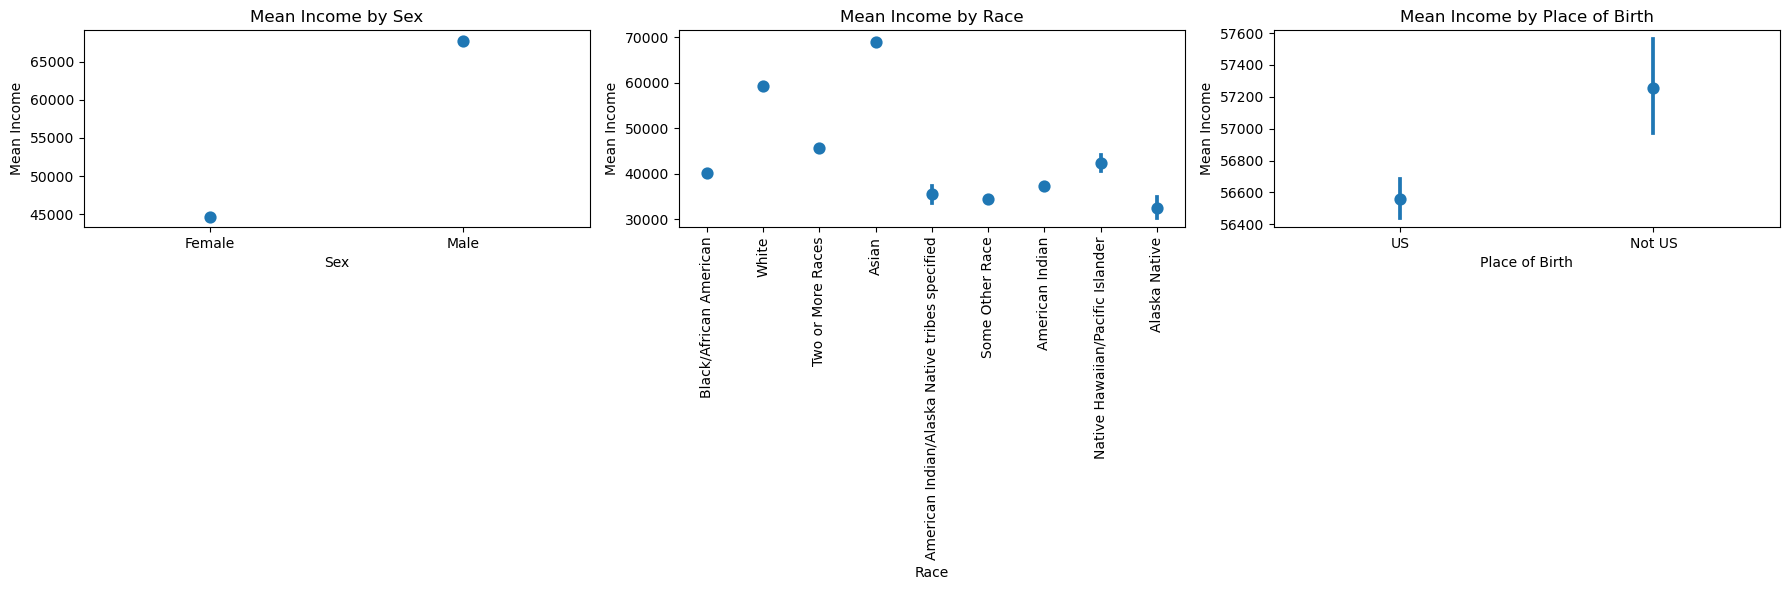

In [16]:
#Βημα 3

#Λόγω:The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

plt.figure(figsize=(18, 6))
# 1. Μέσο εισόδημα ανά φύλο (sex)
plt.subplot(1, 3, 1)
sns.pointplot(data=census_data, x='sex', y='income',linestyle='none', errorbar=('ci', 95))
plt.title("Mean Income by Sex")
plt.ylabel("Mean Income")
plt.xlabel("Sex")

# 2. Μέσο εισόδημα ανά φυλή (race)
plt.subplot(1, 3, 2)
sns.pointplot(data=census_data, x='race', y='income',linestyle='none', errorbar=('ci', 95))
plt.xticks(rotation=90)
plt.title("Mean Income by Race")
plt.ylabel("Mean Income")
plt.xlabel("Race")

# 3. Μέσο εισόδημα ανά καταγωγή (PoB)
plt.subplot(1, 3, 3)
sns.pointplot(data=census_data, x='PoB', y='income',linestyle='none', errorbar=('ci', 95))
plt.title("Mean Income by Place of Birth")
plt.ylabel("Mean Income")
plt.xlabel("Place of Birth")

plt.tight_layout()
plt.show()

Kαταγωγή (PoB) και Κατηγορία Εργασίας (CoW):
Παρατηρήσεις Heatmap:
Η πλειοψηφία των εργαζομένων που είναι γεννημένοι στις Η.Π.Α. εργάζονται ως ιδιωτικοί υπάλληλοι.
Μικρότερος αριθμός από όσους δεν έχουν γεννηθεί στις Η.Π.Α. απασχολούνται στον δημόσιο τομέα, ενώ ένα ποσοστό από αυτούς φαίνεται να είναι αυτοαπασχολούμενοι.
Lift Values:
Αντικατοπτρίζουν διαφορές μεταξύ των παρατηρούμενων και αναμενόμενων τιμών. Π.χ., οι υψηλότερες τιμές lift ίσως δείχνουν ότι η καταγωγή συσχετίζεται με μεγαλύτερη πιθανότητα να εργάζονται σε συγκεκριμένες κατηγορίες (π.χ., "ιδιωτικοί υπάλληλοι" για όσους γεννήθηκαν στις Η.Π.Α.).
Στατιστική Σημασία (p-value):
Το p-value είναι μικρότερο από 0.05, αρα η καταγωγή επηρεάζει σημαντικά την κατηγορία εργασίας.
Φυλή (Race) και Κατηγορία Εργασίας (CoW):
Παρατηρήσεις Heatmap:
Οι "White" φαίνεται να κυριαρχούν στις περισσότερες κατηγορίες, ειδικά στους ιδιωτικούς υπαλλήλους και στους αυτοαπασχολούμενους.
Ορισμένες μειονότητες, όπως οι "Native Hawaiian/Pacific Islander" ή οι "Alaska Native", εμφανίζονται σε μικρούς αριθμούς σε όλες τις κατηγορίες.
Lift Values:
Υψηλές τιμές lift για συγκεκριμένες φυλές (π.χ. "΅White" σε "ιδιωτική εργασία" ή "Black/African American" σε διαφορετικές κατηγορίες) μπορούν να υποδείξουν άνιση κατανομή ευκαιριών.
Στατιστική Σημασία (p-value):
Μικρό p-value υποδεικνύει ότι η φυλή έχει σημαντική επιρροή στην κατηγορία εργασίας.
Φύλο (Sex) και Κατηγορία Εργασίας (CoW):
Παρατηρήσεις Heatmap:
Οι άντρες φαίνεται να είναι περισσότεροι σε κατηγορίες όπως οι αυτοαπασχολούμενοι και οι κυβερνητικοί υπάλληλοι.
Οι γυναίκες ενδέχεται να εμφανίζουν μεγαλύτερη παρουσία σε κατηγορίες χαμηλών εισοδημάτων .
Lift Values:
Οι υψηλές τιμές lift για άντρες ή γυναίκες σε συγκεκριμένες κατηγορίες μπορεί να αντικατοπτρίζουν έμφυλες διαφορές στην επαγγελματική αποκατάσταση.
Στατιστική Σημασία (p-value):
Tο p-value είναι μικρό, αυτό δείχνει ότι το φύλο σχετίζεται στατιστικά με την κατηγορία εργασίας, υποδηλώνοντας πιθανή αδικία ή έλλειψη ίσων ευκαιριών.
Η ύπαρξη στατιστικής σημασίας σε οποιοδήποτε από τα παραπάνω ζεύγη (p-value < 0.05) υποδεικνύει ότι τα χαρακτηριστικά αυτά επηρεάζουν την κατανομή των επαγγελμάτων.
Τα αποτελέσματα με υψηλά lift για συγκεκριμένα ζεύγη τιμών (π.χ. συγκεκριμένες φυλές σε κατηγορίες εργασίας) δείχνουν ότι η κατανομή δεν είναι τυχαία, και ότι υπάρχουν συγκεκριμένες προτιμήσεις ή περιορισμοί για τις αντίστοιχες ομάδες.

In [17]:
# Ανάλυση για το φύλο (sex)
male_income = census_data[census_data['sex'] == 'Male']['income']
female_income = census_data[census_data['sex'] == 'Female']['income']
print(f"Sex t-test(Male vs Female)",stats.ttest_ind(male_income, female_income, equal_var=False))

# Ανάλυση για τη φυλή (race)
races = census_data['race'].unique() 
for i, race1 in enumerate(races):
    for race2 in races[i+1:]:
        income1 = census_data[census_data['race'] == race1]['income']
        income2 = census_data[census_data['race'] == race2]['income']
        print(f"Race t-test ({race1} vs {race2}):", stats.ttest_ind(income1, income2, equal_var=False))

# Ανάλυση για την καταγωγή (PoB)
places = census_data['PoB'].unique()
for i, place1 in enumerate(places):
    for place2 in places[i+1:]:
        income1 = census_data[census_data['PoB'] == place1]['income']
        income2 = census_data[census_data['PoB'] == place2]['income']
        print(f"PoB t-test ({place1} vs {place2}):", stats.ttest_ind(income1, income2, equal_var=False))


Sex t-test(Male vs Female) TtestResult(statistic=210.7054920371594, pvalue=0.0, df=1467023.4821669133)
Race t-test (Black/African American vs White): TtestResult(statistic=-138.2329802095144, pvalue=0.0, df=245798.12613501193)
Race t-test (Black/African American vs Two or More Races): TtestResult(statistic=-17.414999565283168, pvalue=9.538995051817596e-68, df=56655.00981650756)
Race t-test (Black/African American vs Asian): TtestResult(statistic=-95.5403897398624, pvalue=0.0, df=134492.45325391274)
Race t-test (Black/African American vs American Indian/Alaska Native tribes specified): TtestResult(statistic=4.7889540692467065, pvalue=1.7895727419035579e-06, df=2173.0889646328415)
Race t-test (Black/African American vs Some Other Race): TtestResult(statistic=29.248143941123242, pvalue=1.6235576758282591e-187, df=148403.8209305289)
Race t-test (Black/African American vs American Indian): TtestResult(statistic=7.064444329761665, pvalue=1.6858791102930215e-12, df=14535.14827058567)
Race t-t

Sex (Male vs Female):

t = 210.71, p = 0.0: Υπάρχει πολύ μεγάλη στατιστική σημασία στη διαφορά ανάμεσα στα δύο φύλα.
Race Comparisons:

Race Comparisons:
Πολλές από τις φυλετικές συγκρίσεις δείχνουν εξαιρετικά στατιστικά σημαντικές διαφορές (p ≈ 0.0), εκτός από:
Black vs Native Hawaiian/Pacific Islander (p = 0.0145): Σημαντική αλλά λιγότερο έντονη διαφορά.
American Indian/Alaska Native tribes specified vs Some Other Race (p = 0.287): Μη στατιστικά σημαντική διαφορά.
American Indian vs Alaska Native (p = 0.057): Οριακά μη στατιστικά σημαντική.
Some Other Race vs Alaska Native (p = 0.119): Μη στατιστικά σημαντική διαφορά.
Place of Birth (US vs Not US):

Place of Birth (US vs Not US):
t = -4.34, p = 0.000014: Υπάρχει στατιστικά σημαντική διαφορά ανάμεσα στα άτομα που γεννήθηκαν στις ΗΠΑ και σε εκείνα που γεννήθηκαν εκτός.
Ερμηνεία στατιστικού t:

Οι θετικές τιμές δείχνουν ότι η πρώτη ομάδα έχει υψηλότερο μέσο όρο από τη δεύτερη, ενώ οι αρνητικές δείχνουν το αντίθετο.

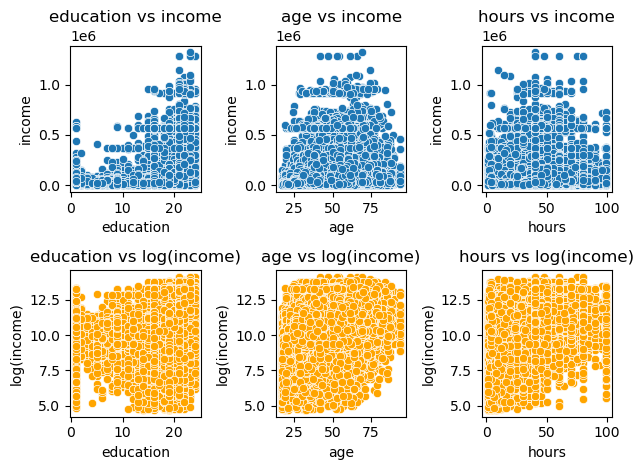

In [18]:
#

california_data = census_data[census_data['state'] == 'California']
attributes = ['education', 'age', 'hours']
for i, attr in enumerate(attributes):
    # Scatter plots με το εισόδημα
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(data=california_data, x=attr, y='income')
    plt.title(f"{attr} vs income")
    plt.xlabel(attr)
    plt.ylabel("income")
    
    # Scatter plots με τον λογάριθμο του εισοδήματος
    plt.subplot(2, 3, i + 4)
    sns.scatterplot(data=california_data, x=attr, y='log_income', color='orange')
    plt.title(f"{attr} vs log(income)")
    plt.xlabel(attr)
    plt.ylabel("log(income)")

plt.tight_layout()
plt.show()

 Εισόδημα και Εκπαίδευση (Education vs Income):
a)Το scatterplot δείχνει μια θετική τάση, όπου υψηλότερα επίπεδα εκπαίδευσης συνδέονται με μεγαλύτερο εισόδημα.
Ο συντελεστής Pearson για την Καλιφόρνια είναι 0.282 για το εισόδημα και 0.305 για το λογαριθμικο εισόδημα, υποδεικνύοντας χαμηλή προς μέτρια θετική συσχέτιση.
b) Εισόδημα και Ηλικία (Age vs Income):
Υπάρχει επίσης θετική συσχέτιση, αλλά λιγότερο έντονη (0.234 για το εισόδημα, 0.359 για το log-income).
Η τάση δείχνει ότι το εισόδημα αυξάνεται με την ηλικία, μέχρι ένα σημείο όπου παρατηρείται κορεσμός.
c) Εισόδημα και Ώρες Εργασίας (Hours vs Income):
Η συσχέτιση είναι υψηλότερη, ειδικά για το λογαριθμικο εισόδημα (0.508), δείχνοντας ότι περισσότερες ώρες εργασίας συνδέονται με μεγαλύτερο εισόδημα.


In [19]:
for attr in (attributes):
    print(f" Pearson Correlation for CA (income vs {attr}):",stats.pearsonr(california_data.income,california_data[attr]))
    print(f" Pearson Correlation for CA (log_income vs {attr}):",stats.pearsonr(california_data.log_income,california_data[attr]))


 Pearson Correlation for CA (income vs education): PearsonRResult(statistic=0.2822070268229643, pvalue=0.0)
 Pearson Correlation for CA (log_income vs education): PearsonRResult(statistic=0.30535315044031214, pvalue=0.0)
 Pearson Correlation for CA (income vs age): PearsonRResult(statistic=0.2347919499485816, pvalue=0.0)
 Pearson Correlation for CA (log_income vs age): PearsonRResult(statistic=0.35876670897426505, pvalue=0.0)
 Pearson Correlation for CA (income vs hours): PearsonRResult(statistic=0.2973284478598754, pvalue=0.0)
 Pearson Correlation for CA (log_income vs hours): PearsonRResult(statistic=0.50774871734666, pvalue=0.0)


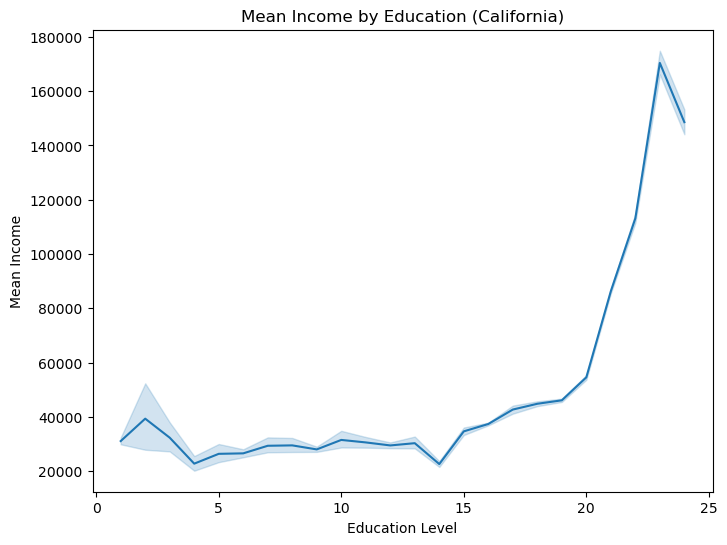

In [27]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=california_data, x='education', y='income',errorbar=('ci', 95))
plt.title("Mean Income by Education (California)")
plt.xlabel("Education Level")
plt.ylabel("Mean Income")

plt.show()

Γραφήματα Μέσης Τιμής Εισοδήματος κατά Εκπαίδευση:
Το δεύτερο γράφημα δείχνει τη μέση τιμή του εισοδήματος ανά επίπεδο εκπαίδευσης στην Καλιφόρνια.
Υπάρχει σαφής αύξηση του εισοδήματος σε υψηλότερα επίπεδα εκπαίδευσης, ειδικά μετά το επίπεδο 20, που πιθανότατα αντιστοιχεί σε πτυχία ή διδακτορικές σπουδές.

Συμπέρασμα
Η εκπαίδευση έχει σημαντική συσχέτιση με το εισόδημα. Τα άτομα με περισσότερα χρόνια εκπαίδευσης έχουν υψηλότερο εισόδημα.
Η ηλικία σχετίζεται θετικά με το εισόδημα, αν και η συσχέτιση είναι πιο έντονη για το λογαριθμικο εισόδημα.
Οι ώρες εργασίας επηρεάζουν ισχυρά το εισόδημα, ιδιαίτερα όταν εξετάζουμε το λογαριθμικο εισόδημα, που μπορεί να δείχνει ότι οι επιπλέον ώρες έχουν μειωμένη απόδοση στο ακαθάριστο εισόδημα.
Τα στοιχεία δείχνουν σημαντική ανισότητα στο εισόδημα, με αυξημένο εισόδημα στα υψηλότερα επίπεδα εκπαίδευσης.

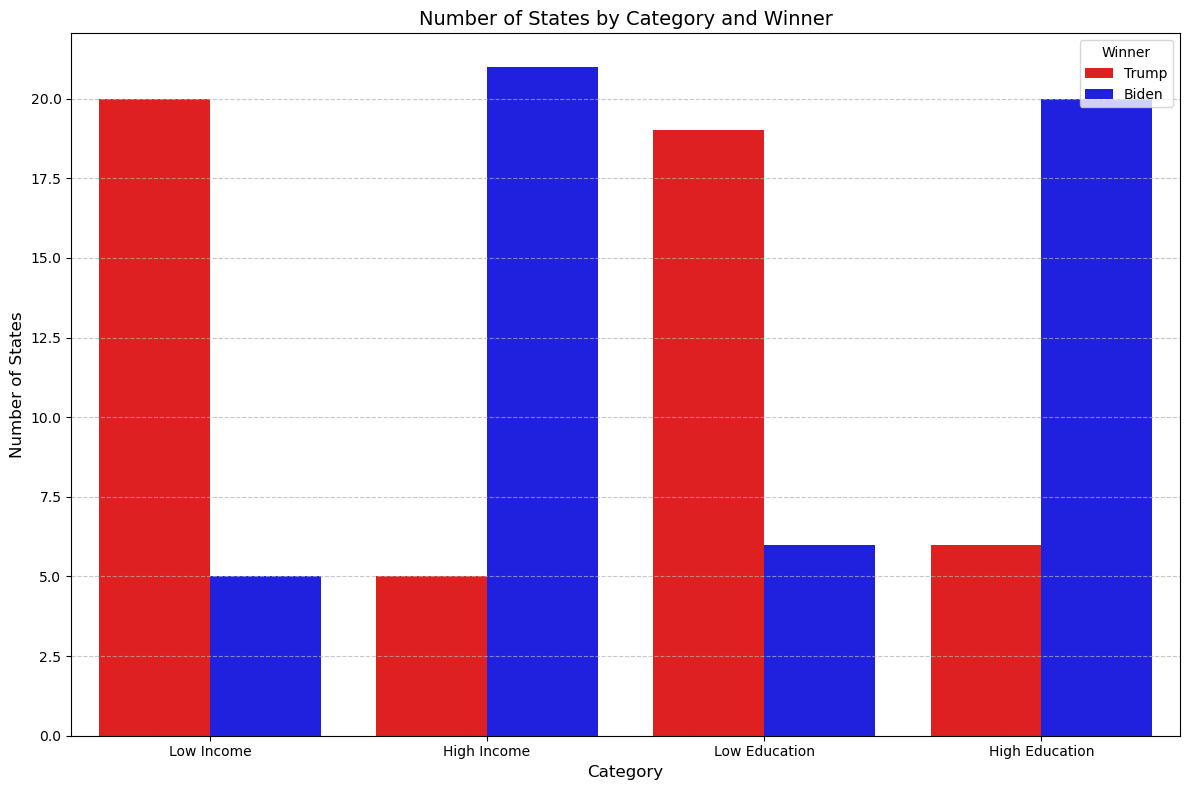

In [21]:
#Βήμα 5

voting_data = pd.read_csv('voting-2020.csv') 
states = census_data['state'].unique()
mean_income_per_state = {}
mean_education_level_per_state ={}
for state in states:
    state_data = census_data[census_data['state'] == state]
    mean_income = state_data['income'].mean()
    mean_income_per_state[state] = mean_income
    mean_education_level = state_data['education'].mean()
    mean_income_per_state[state] = mean_income
    mean_education_level_per_state[state] = mean_education_level
    

voting_data['mean_income'] = voting_data['state'].map(mean_income_per_state)
voting_data['mean_education_level'] = voting_data['state'].map(mean_education_level_per_state)

median_income = voting_data['mean_income'].median()
median_education_level = voting_data['mean_education_level'].median()

category_counts_df = pd.DataFrame([
    {"Category": "Low Income", "Winner": "Trump", "Count": 0},
    {"Category": "Low Income", "Winner": "Biden", "Count": 0},
    {"Category": "High Income", "Winner": "Trump", "Count": 0},
    {"Category": "High Income", "Winner": "Biden", "Count": 0},
    {"Category": "Low Education", "Winner": "Trump", "Count": 0},
    {"Category": "Low Education", "Winner": "Biden", "Count": 0},
    {"Category": "High Education", "Winner": "Trump", "Count": 0},
    {"Category": "High Education", "Winner": "Biden", "Count": 0},
])

for idx, row in voting_data.iterrows():
    if row['mean_income'] < median_income:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Income') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Income') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1
    else:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Income') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Income') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1
    
    if row['mean_education_level'] < median_education_level:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Education') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Education') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1
    else:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Education') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Education') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1

plt.figure(figsize=(12, 8))
sns.barplot(
    data=category_counts_df,
    x="Category",
    y="Count",
    hue="Winner",
    palette={"Trump": "red", "Biden": "blue"}
)
plt.title("Number of States by Category and Winner", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of States", fontsize=12)
plt.legend(title="Winner")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
# Διαχωρισμός πολιτειών βάσει εισοδήματος
low_income_trump = voting_data[voting_data['mean_income'] < median_income]['trump_pct']
high_income_trump = voting_data[voting_data['mean_income'] >= median_income]['trump_pct']

# Διαχωρισμός πολιτειών βάσει εκπαίδευσης
low_education_biden = voting_data[voting_data['mean_education_level'] < median_education_level]['biden_pct']
high_education_biden = voting_data[voting_data['mean_education_level'] >= median_education_level]['biden_pct']



# Εμφάνιση αποτελεσμάτων
print(f"T-test for Income (Trump Wins): t-statistic = ", stats.ttest_ind(low_income_biden,high_income_trump, equal_var=False))
print(f"T-test for Education (Biden Wins): t-statistic = ",stats.ttest_ind(high_education_trump, low_education_biden, equal_var=False))

T-test for Income (Trump Wins): t-statistic =  TtestResult(statistic=-1.036686092566959, pvalue=0.30514959396017716, df=47.33218724056354)
T-test for Education (Biden Wins): t-statistic =  TtestResult(statistic=1.0272218968212403, pvalue=0.30948273358782674, df=47.83274273735923)


Γραφική Παράσταση:

Στην κατηγορία "Low Income", ο Trump κέρδισε σε περισσότερες πολιτείες (κόκκινη μπάρα μεγαλύτερη από την μπλε).
Στην κατηγορία "High Income", ο Biden κέρδισε σε περισσότερες πολιτείες (μπλε μπάρα μεγαλύτερη από την κόκκινη).
Στην κατηγορία "Low Education", ο Trump εμφανίζει ισχυρή υπεροχή.
Στην κατηγορία "High Education", ο Biden έχει ξεκάθαρη υπεροχή.
Στατιστική Ανάλυση (T-test):

Income (Trump Wins): Το p-value είναι 0.305 (μεγαλύτερο από 0.05), δείχνοντας ότι δεν υπάρχει στατιστικά σημαντική διαφορά στο εισόδημα των πολιτειών που κέρδισε ο Trump.
Education (Biden Wins): Το p-value είναι 0.309 (επίσης μεγαλύτερο από 0.05), πράγμα που σημαίνει ότι δεν υπάρχει στατιστικά σημαντική διαφορά στο επίπεδο εκπαίδευσης των πολιτειών που κέρδισε ο Biden.
Συμπεράσματα:

Παρά τις εμφανείς διαφορές στις κατηγορίες στη γραφική παράσταση, η στατιστική ανάλυση δείχνει ότι οι διαφορές αυτές δεν είναι στατιστικά σημαντικές.
Η επίδραση του εισοδήματος και της εκπαίδευσης φαίνεται να έχει κάποια σχέση με τα αποτελέσματα στις πολιτείες, αλλά δεν επαρκεί από μόνη της για να εξηγήσει τις διαφορές μεταξύ Trump και Biden. Άλλοι παράγοντες πιθανότατα παίζουν πιο σημαντικό ρόλο.


Βημα 6 
Υπόθεση 1η:
Εξετάζουμε την υπόθεση αν η οικογενειακή κατάσταση επιρρεάζει το εισόδημα

Text(0.5, 0, 'Marital Status')

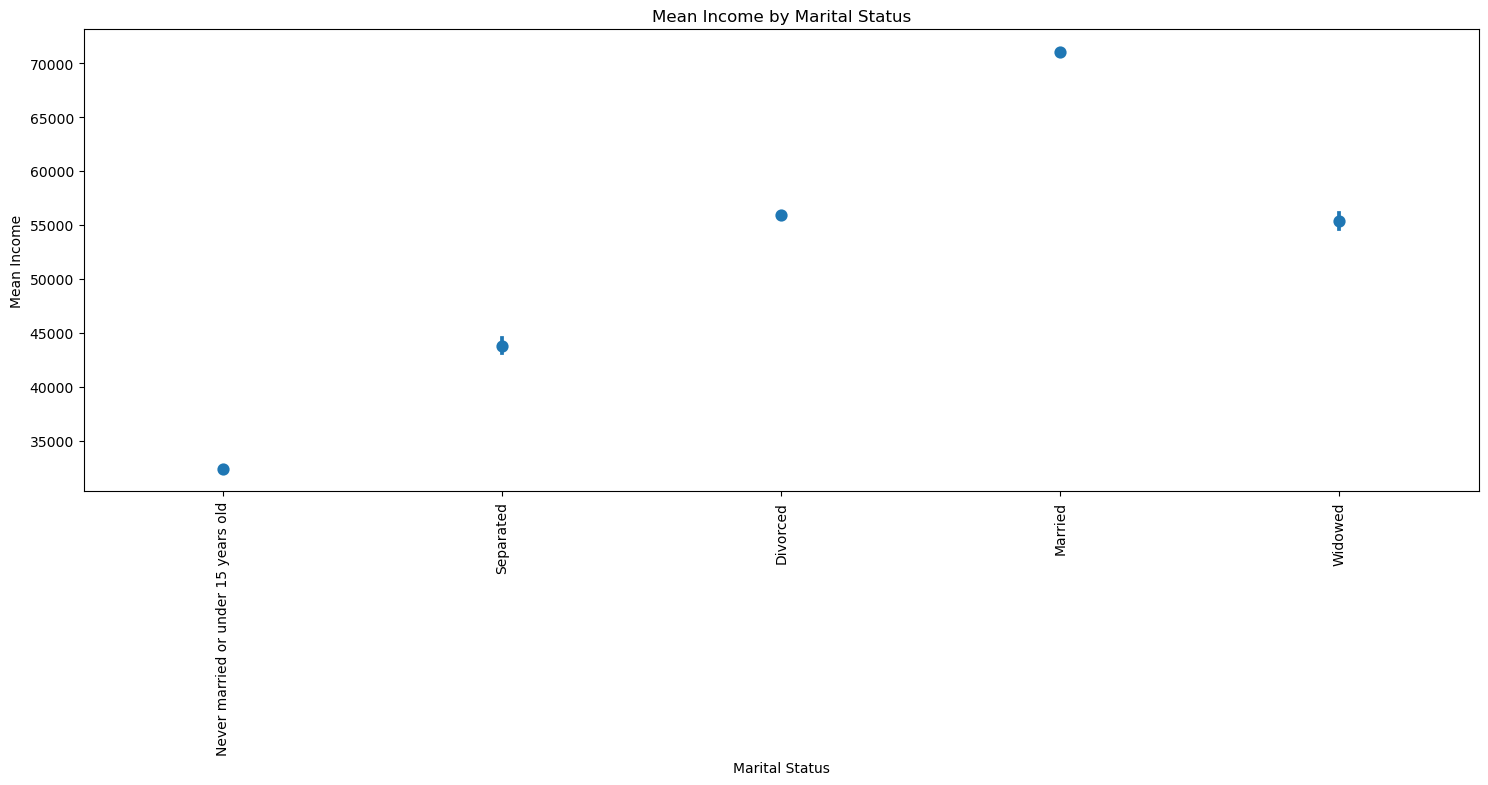

In [23]:
#Μέσο εισόδημα ανά οικογενειακή κατάσταση (marital)
plt.figure(figsize=(18, 6))
sns.pointplot(data=census_data, x='marital', y='income',linestyle='none', errorbar=('ci', 95))
plt.xticks(rotation=90)
plt.title("Mean Income by Marital Status")
plt.ylabel("Mean Income")
plt.xlabel("Marital Status")


In [24]:
marital_statuses = census_data['marital'].unique() 
for i, marital_status1 in enumerate(marital_statuses):
    for marital_status2 in marital_statuses[i+1:]:
        income1 = census_data[census_data['marital'] == marital_status1]['income']
        income2 = census_data[census_data['marital'] == marital_status2]['income']
        print(f"Marital status t-test ({marital_status1} vs {marital_status2}):", stats.ttest_ind(income1, income2, equal_var=False))

Marital status t-test (Never married or under 15 years old vs Separated): TtestResult(statistic=-34.76758119607847, pvalue=9.342365434638848e-260, df=30389.891460935745)
Marital status t-test (Never married or under 15 years old vs Divorced): TtestResult(statistic=-148.48621024253126, pvalue=0.0, df=239495.80494889783)
Marital status t-test (Never married or under 15 years old vs Married): TtestResult(statistic=-361.68878696637387, pvalue=0.0, df=1405059.1850090406)
Marital status t-test (Never married or under 15 years old vs Widowed): TtestResult(statistic=-64.10612266149106, pvalue=0.0, df=36544.01882497374)
Marital status t-test (Separated vs Divorced): TtestResult(statistic=-34.0235384689646, pvalue=3.0140132563898345e-250, df=41119.8512363106)
Marital status t-test (Separated vs Married): TtestResult(statistic=-81.10564607271716, pvalue=0.0, df=32905.91812630845)
Marital status t-test (Separated vs Widowed): TtestResult(statistic=-24.134015156378588, pvalue=4.2055513131084073e-12

Συμπεράσματα:
"Never married or under 15 years old" vs άλλες κατηγορίες:
   
Separated:
T-statistic: -34.77 (αρνητική διαφορά μέσων).
P-value: 9.34e-260 (εξαιρετικά μικρό, στατιστικά σημαντικό).
Συμπέρασμα: Οι  "Never married or under 15 years old" έχουν σημαντικά χαμηλότερο εισόδημα από τους "Separated".
Divorced:
T-statistic: -148.49.
P-value: 0.0 (στατιστικά σημαντικό).
Συμπέρασμα: Σημαντικά χαμηλότερο εισόδημα για την κατηγορία "Never married or under 15 years old" σε σχέση με τους "Divorced".
Married:
T-statistic: -361.69.
P-value: 0.0.
Συμπέρασμα: Το εισόδημα αυτής της κατηγορίας είναι εξαιρετικά χαμηλότερο σε σύγκριση με την κατηγορία των "Married".
Widowed:
T-statistic: -64.11.
P-value: 0.0.
Συμπέρασμα: Χαμηλότερο εισόδημα σε σχέση με την κατηγορία "Widowed".

2. "Separated" vs άλλες κατηγορίες:
Divorced:
T-statistic: -34.02.
P-value: 3.01e-250.
Συμπέρασμα: Οι "Separated" έχουν σημαντικά χαμηλότερο εισόδημα από τους "Divorced".
Married:
T-statistic: -81.11.
P-value: 0.0.
Συμπέρασμα: Οι "Separated" έχουν επίσης πολύ χαμηλότερο εισόδημα από τους "Married".
Widowed:
T-statistic: -24.13.
P-value: 4.21e-128.
Συμπέρασμα: Οι "Separated" έχουν χαμηλότερο εισόδημα από τους "Widowed".

4. "Divorced" vs άλλες κατηγορίες:
Married:
T-statistic: -88.06.
P-value: 0.0.
Συμπέρασμα: Οι "Divorced" έχουν χαμηλότερο εισόδημα από τους "Married".
Widowed:
T-statistic: 1.35.
P-value: 0.178 (μη στατιστικά σημαντικό).
Συμπέρασμα: Δεν υπάρχει στατιστικά σημαντική διαφορά στο εισόδημα μεταξύ των "Divorced" και των "Widowed".


4. "Married" vs "Widowed":
T-statistic: 42.85.
P-value: 0.0.
Συμπέρασμα: Οι "Married" έχουν σημαντικά υψηλότερο εισόδημα σε σχέση με τους "Widowed".

Γενικά Συμπεράσματα:
Οι "Married" έχουν το υψηλότερο εισόδημα ανάμεσα σε όλες τις κατηγορίες.
Οι "Never married or under 15 years old" έχουν το χαμηλότερο εισόδημα.
Η κατηγορία "Widowed" βρίσκεται σε ενδιάμεσο επίπεδο, ενώ οι "Separated" και "Divorced" κυμαίνονται σε παρόμοια, αλλά κάπως χαμηλότερα επίπεδα από τους "Married".



Bήμα 6 
Υπόθεση 2η :
Εξετάζουμε την υπόθεση αν οι πολιτείες με μεγαλύτερο μέσο όρο ηλικίας ψήφησαν Trump

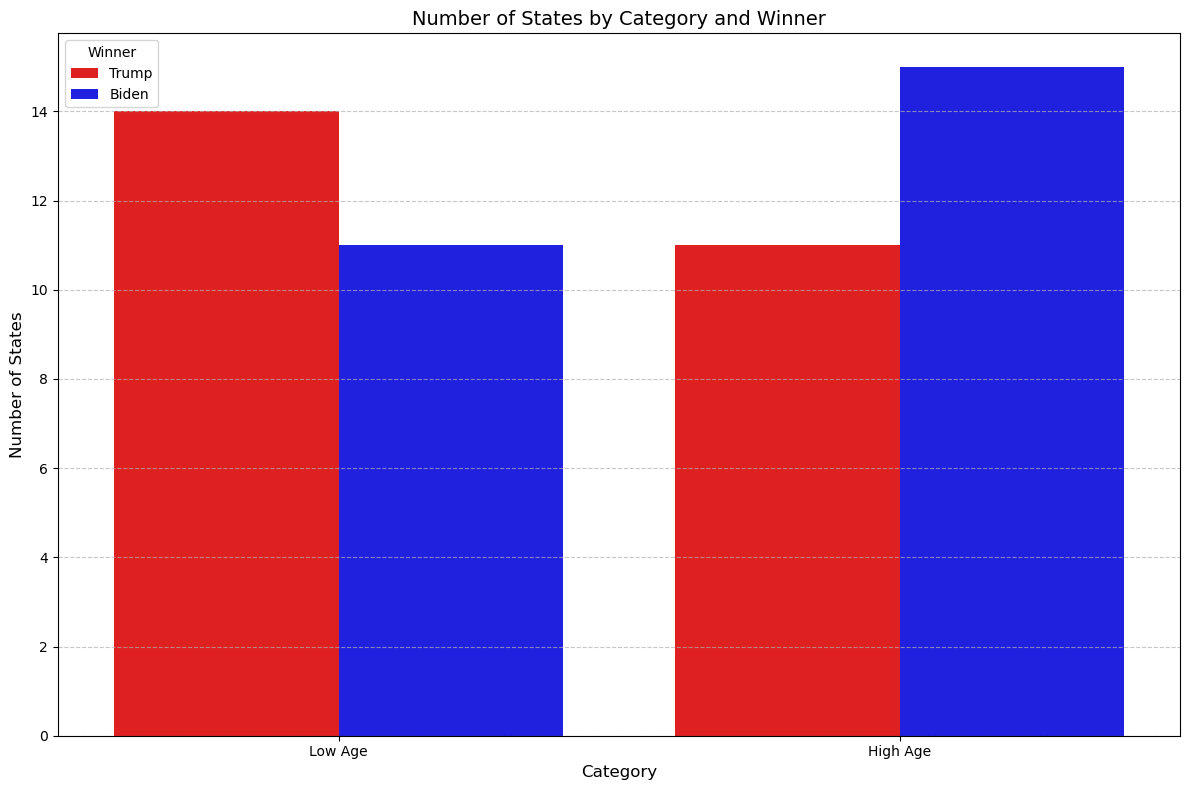

In [25]:
states = census_data['state'].unique()
mean_age_per_state ={}
for state in states:
    state_data = census_data[census_data['state'] == state]
    mean_age = state_data['age'].mean()
    mean_age_per_state[state] = mean_age
    
voting_data['mean_age'] = voting_data['state'].map(mean_age_per_state)

median_age = voting_data['mean_age'].median()

category_counts_df = pd.DataFrame([
    {"Category": "Low Age", "Winner": "Trump", "Count": 0},
    {"Category": "Low Age", "Winner": "Biden", "Count": 0},
    {"Category": "High Age", "Winner": "Trump", "Count": 0},
    {"Category": "High Age", "Winner": "Biden", "Count": 0}
])

for idx, row in voting_data.iterrows():
    if row['mean_age'] < median_age:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Age') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'Low Age') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1
    else:
        if row['trump_win']:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Age') & (category_counts_df['Winner'] == 'Trump'), 'Count'] += 1
        else:
            category_counts_df.loc[(category_counts_df['Category'] == 'High Age') & (category_counts_df['Winner'] == 'Biden'), 'Count'] += 1

plt.figure(figsize=(12, 8))
sns.barplot(
    data=category_counts_df,
    x="Category",
    y="Count",
    hue="Winner",
    palette={"Trump": "red", "Biden": "blue"}
)
plt.title("Number of States by Category and Winner", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of States", fontsize=12)
plt.legend(title="Winner")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
# Διαχωρισμός πολιτειών βάσει εισοδήματος
low_age_trump = voting_data[voting_data['mean_age'] < median_age]['trump_pct']
high_age_trump = voting_data[voting_data['mean_age'] < median_income]['trump_pct']


low_age_biden = voting_data[voting_data['mean_age'] < median_age]['biden_pct']
high_age_biden = voting_data[voting_data['mean_age'] < median_income]['biden_pct']


print(f"T-test for Age (Trump Wins): t-statistic = ", stats.ttest_ind(low_age_trump,high_age_trump, equal_var=False))
print(f"T-test for Age (Biden Wins): t-statistic = ",stats.ttest_ind(low_age_biden, high_age_biden, equal_var=False))

T-test for Age (Trump Wins): t-statistic =  TtestResult(statistic=0.4157821015952318, pvalue=0.6793339068800444, df=50.41760679229187)
T-test for Age (Biden Wins): t-statistic =  TtestResult(statistic=-0.44853779625002127, pvalue=0.6556829691309503, df=50.52319930540791)


Γραφική Παράσταση:

Στην κατηγορία "Low Age", παρατηρούμε ότι περισσότερες πολιτείες στις οποίες κέρδισε ο Trump αντιστοιχούν σε αυτή την κατηγορία (κόκκινη μπάρα μεγαλύτερη από την μπλε).
Αντίστροφα, στην κατηγορία "High Age", περισσότερες πολιτείες όπου κέρδισε ο Biden εμφανίζονται σε αυτή την κατηγορία (μπλε μπάρα μεγαλύτερη από την κόκκινη).
Στατιστική Ανάλυση (T-test):

Για τις πολιτείες που κέρδισε ο Trump: Η τιμή του p-value είναι 0.679 (πολύ μεγαλύτερη από 0.05). Αυτό σημαίνει ότι δεν υπάρχουν στατιστικά σημαντικές διαφορές στην ηλικία.
Για τις πολιτείες που κέρδισε ο Biden: Η τιμή του p-value είναι 0.656 (επίσης μεγαλύτερη από 0.05). Και εδώ, δεν παρατηρούνται στατιστικά σημαντικές διαφορές στην ηλικία.
Συμπεράσματα:

Παρά τις διαφορές που παρατηρούνται στη γραφική παράσταση, η στατιστική ανάλυση δείχνει ότι δεν υπάρχουν στατιστικά σημαντικές συσχετίσεις μεταξύ της ηλικιακής κατηγορίας (Low Age, High Age) και της νίκης του Trump ή του Biden.
Ενδεχομένως η ηλικία να μην αποτελεί αποφασιστικό παράγοντα για την επικράτηση σε κάθε πολιτεία, αλλά μόνο ένα από τα στοιχεία που θα μπορούσαν να επηρεάζουν την ψήφο.